# Deep learning examples

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/etna-team/etna/master?filepath=examples/202-NN_examples.ipynb)



**Table of contents**

* [Loading dataset](#chapter1)  
* [Architecture](#chapter2)
* [Testing models](#chapter3)
    * [Baseline](#section_3_1)
    * [DeepAR](#section_3_2)
    * [RNN](#section_3_4)
    * [Deep State Model](#section_3_5)
    * [N-BEATS Model](#section_3_6)
    * [PatchTS Model](#section_3_7)

## Преимущество MLP над классическими моделями регрессии

-	Экстраполяция: MLP-модели лучше справляются с экстраполяцией по сравнению с деревьями решений, при этом они мощнее, чем простая линейная регрессия.
- Гибкость: MLP легко преобразовать в вероятностную модель, изменив функцию потерь и последний слой.

    Например, если в задаче нужно предсказывать распределение, а не просто какую-то статистику (меняем последний слой сетки и предсказываем параметры этого распределения вместо конкретного значения).

In [ ]:
# !pip install "etna[torch]" -q

In [ ]:
import warnings

warnings.filterwarnings("ignore")

In [ ]:
import random

import numpy as np
import pandas as pd
import torch

from etna.analysis import plot_backtest
from etna.datasets.tsdataset import TSDataset
from etna.metrics import MAE
from etna.metrics import MAPE
from etna.metrics import SMAPE
from etna.models import SeasonalMovingAverageModel
from etna.pipeline import Pipeline
from etna.transforms import DateFlagsTransform
from etna.transforms import LagTransform
from etna.transforms import LinearTrendTransform


metrics = [SMAPE(), MAPE(), MAE()]

In [ ]:
def set_seed(seed: int = 42):
    """Set random seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

## 1. Загрузите датасет <a class="anchor" id="chapter1"></a>

In [ ]:
original_df = pd.read_csv("example_dataset.csv")
original_df.head()

,timestamp,segment,target
0,2019-01-01,segment_a,170
1,2019-01-02,segment_a,243
2,2019-01-03,segment_a,267
3,2019-01-04,segment_a,287
4,2019-01-05,segment_a,279


Библиотека работает со специальной структурой данных `TSDataset`.

In [ ]:
df = TSDataset.to_dataset(original_df)
ts = TSDataset(df, freq="D")
ts.head(5)

segment,segment_a,segment_b,segment_c,segment_d
feature,target,target,target,target
timestamp,,,,
2019-01-01,170,102,92,238
2019-01-02,243,123,107,358
2019-01-03,267,130,103,366
2019-01-04,287,138,103,385
2019-01-05,279,137,104,384


## 2. Протестируйте модель <a class="anchor" id="chapter3"></a>

In [ ]:
HORIZON = 7
metrics = [SMAPE(), MAPE(), MAE()]

In [ ]:
num_lags = 10
transform_lag = LagTransform(
    in_column="target",
    lags=[HORIZON + i for i in range(num_lags)],
    out_column="target_lag",
)

### 2.1. Baseline <a class="anchor" id="section_3_1"></a>

In [ ]:
model_sma = SeasonalMovingAverageModel(window=5, seasonality=7)
linear_trend_transform = LinearTrendTransform(in_column="target")

pipeline_sma = Pipeline(model=model_sma, horizon=HORIZON, transforms=[linear_trend_transform])

In [ ]:
metrics_sma, forecast_sma, fold_info_sma = pipeline_sma.backtest(ts, metrics=metrics, n_folds=3, n_jobs=1)

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s


In [ ]:
score = metrics_sma["SMAPE"].mean()
print(f"Average SMAPE for Seasonal MA: {score:.3f}")

Average SMAPE for Seasonal MA: 5.547


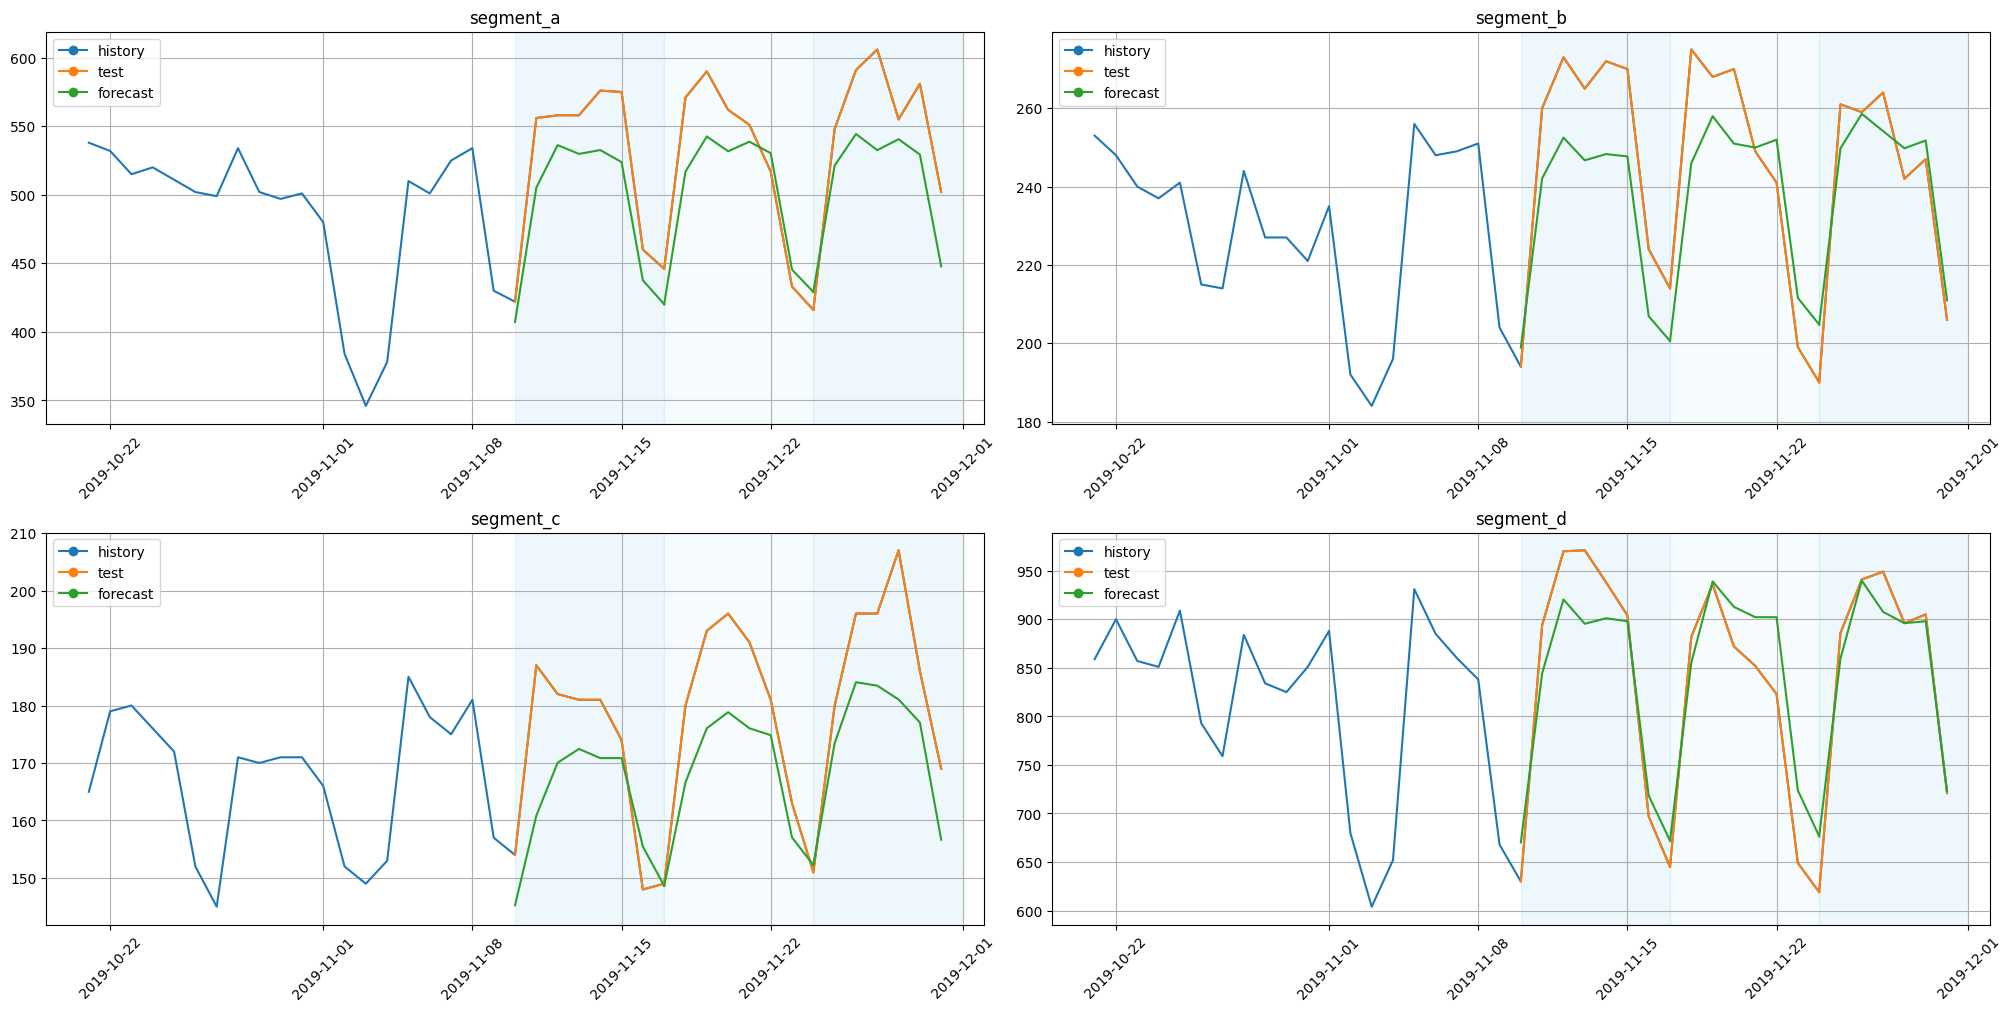

In [ ]:
plot_backtest(forecast_sma, ts, history_len=20)

# 2.2. DeepAR <a class="anchor" id="section_3_2"></a>

In [ ]:
from etna.models.nn import DeepARModel

In [ ]:
set_seed()

#### Default way

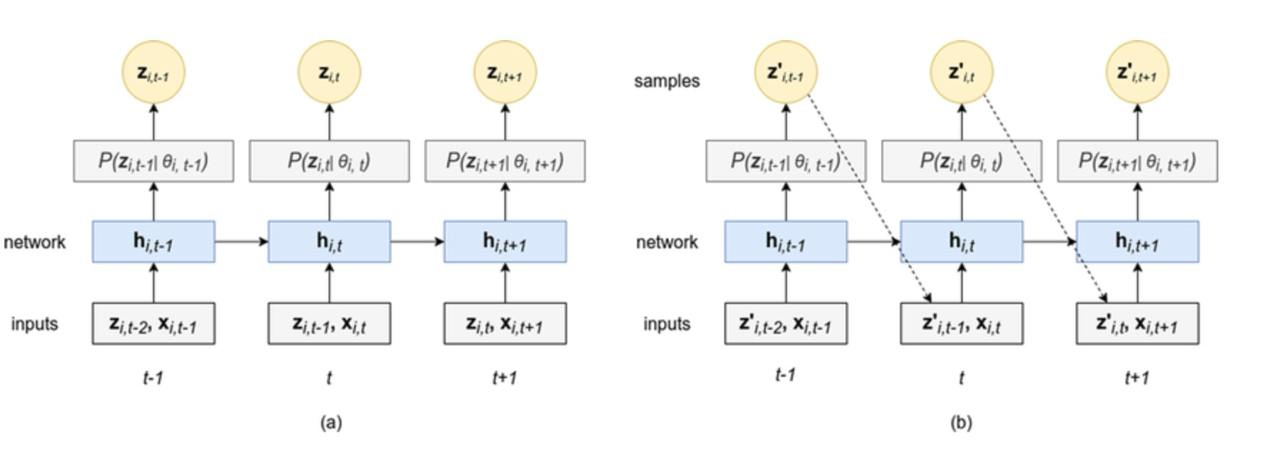


David Salinas, Valentin Flunkert, Jan Gasthaus / arxiv.org

Дополнительная литература: https://arxiv.org/abs/1704.04110

In [ ]:
model_deepar = DeepARModel(
    encoder_length=HORIZON,
    decoder_length=HORIZON,
    trainer_params=dict(max_epochs=150, gpus=0, gradient_clip_val=0.1),
    lr=0.01,
    train_batch_size=64,
)
metrics = [SMAPE(), MAPE(), MAE()]

pipeline_deepar = Pipeline(model=model_deepar, horizon=HORIZON)

In [ ]:
metrics_deepar, forecast_deepar, fold_info_deepar = pipeline_deepar.backtest(ts, metrics=metrics, n_folds=3, n_jobs=1)

c:\Users\apodkidyshev\.conda\envs\etna\lib\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 0     
3 | rnn                    | LSTM                   | 1.6 K 
4 | distribution_projector | Linear                 | 22    
------------------------------------------------------------------
1.6 K     Trainable params
0         Non-trainable params
1.6 K     Total params
0.006     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  3.8min
c:\Users\apodkidyshev\.conda\envs\etna\lib\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 0     
3 | rnn                    | LSTM                   | 1.6 K 
4 | distribution_projector | Linear                 | 2

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:  7.8min
c:\Users\apodkidyshev\.conda\envs\etna\lib\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 0     
3 | rnn                    | LSTM                   | 1.6 K 
4 | distribution_projector | Linear                 | 2

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed: 11.8min
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed: 11.8min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s


In [ ]:
metrics_deepar

,segment,SMAPE,MAPE,MAE,fold_number
0,segment_a,7.435932,7.181695,38.649043,0
0,segment_a,4.475635,4.612648,22.656817,1
0,segment_a,10.447337,9.920778,54.777326,2
1,segment_b,7.934737,7.638955,19.769756,0
1,segment_b,5.531232,5.611022,13.110171,1
1,segment_b,4.139600,4.343228,9.261771,2
2,segment_c,3.846279,3.858180,6.489208,0
2,segment_c,5.991871,5.917592,10.582668,1
2,segment_c,6.220788,6.153255,11.090376,2
3,segment_d,7.151515,7.089699,60.375985,0


Подводя итог, мы возьмем среднее значение метрики SMAPE, поскольку оно устойчиво к масштабированию.

In [ ]:
score = metrics_deepar["SMAPE"].mean()
print(f"Average SMAPE for DeepAR: {score:.3f}")

Average SMAPE for DeepAR: 5.971


###2.3. TFT <a class="anchor" id="section_3_3"></a>

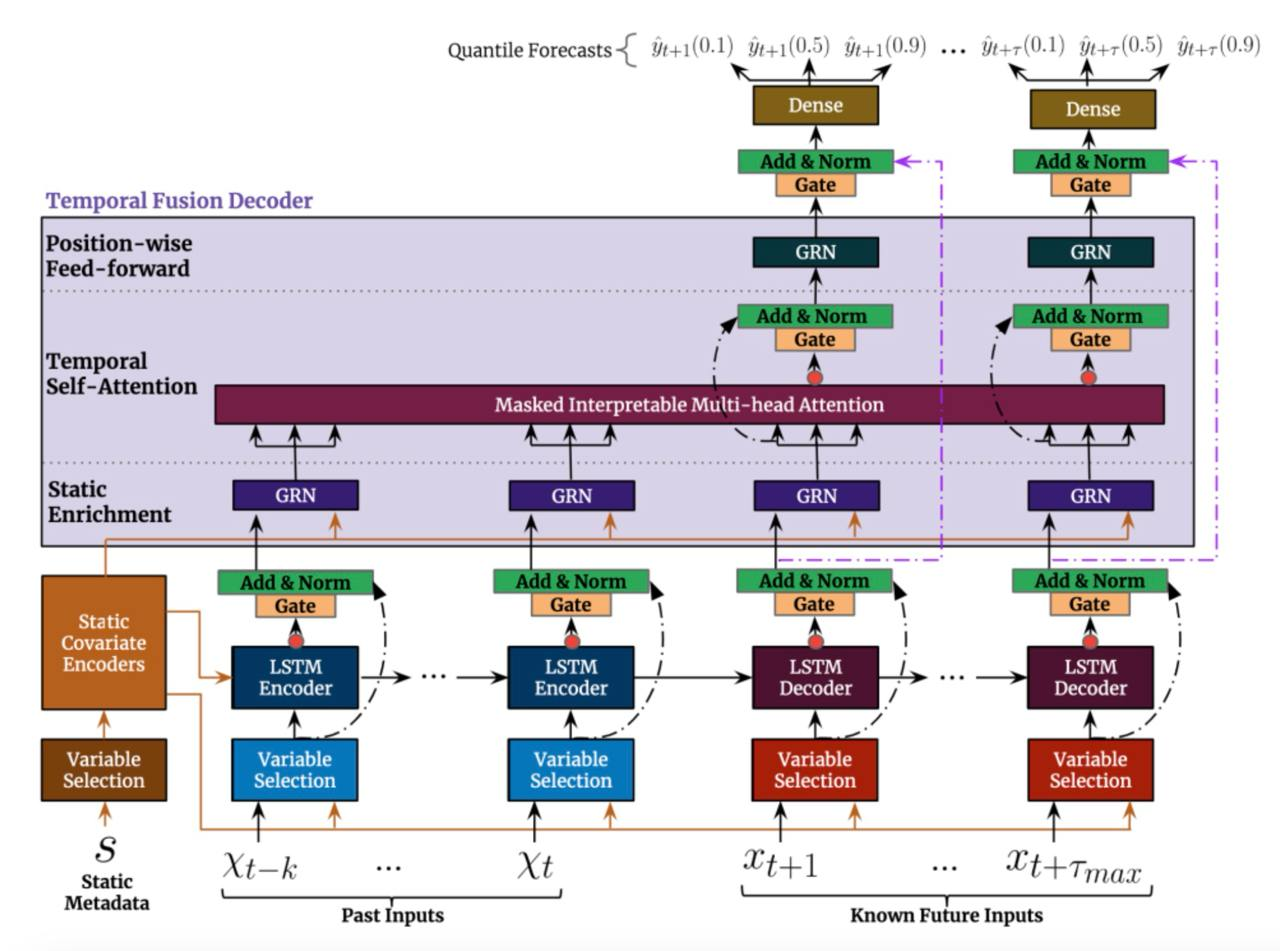

Bryan Lim, Sercan O. Arik, Nicolas Loeff, Tomas Pfister / arxiv.org

Дополнительная литература: https://arxiv.org/abs/1912.09363

In [ ]:
from etna.models.nn import TFTModel

In [ ]:
set_seed()

#### Default way

In [ ]:
model_tft = TFTModel(
    encoder_length=HORIZON,
    decoder_length=HORIZON,
    trainer_params=dict(max_epochs=200, gpus=0, gradient_clip_val=0.1),
    lr=0.01,
    train_batch_size=64,
)

pipeline_tft = Pipeline(
    model=model_tft,
    horizon=HORIZON,
)

In [ ]:
metrics_tft, forecast_tft, fold_info_tft = pipeline_tft.backtest(ts, metrics=metrics, n_folds=3, n_jobs=1)

c:\Users\apodkidyshev\.conda\envs\etna\lib\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 96    
4  | static_variable_selection   

Training: 0it [00:00, ?it/s]

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  9.7min
c:\Users\apodkidyshev\.conda\envs\etna\lib\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict   

Training: 0it [00:00, ?it/s]

In [ ]:
metrics_tft

,segment,SMAPE,MAPE,MAE,fold_number
0,segment_a,41.295280,33.860392,183.798841,0
0,segment_a,11.996966,11.630031,61.497934,1
0,segment_a,10.082110,9.658765,53.090049,2
1,segment_b,32.172957,39.575347,94.343999,0
1,segment_b,11.343108,11.090066,27.261178,1
1,segment_b,7.169835,7.333611,16.287188,2
2,segment_c,67.032135,101.800896,173.058289,0
2,segment_c,12.600207,11.781352,21.810475,1
2,segment_c,9.291467,9.139920,16.771430,2
3,segment_d,83.714331,58.675589,512.227408,0


In [ ]:
score = metrics_tft["SMAPE"].mean()
print(f"Average SMAPE for TFT: {score:.3f}")

Average SMAPE for TFT: 27.460


### 2.4. RNN <a class="anchor" id="section_3_4"></a>

We'll use RNN model based on LSTM cell

In [ ]:
from etna.models.nn import RNNModel
from etna.transforms import StandardScalerTransform

In [ ]:
len(transform_lag.lags)

10

In [ ]:
model_rnn = RNNModel(
    decoder_length=HORIZON,
    encoder_length=2 * HORIZON,
    input_size=11, # len(transform_lag.lags) + 1
    trainer_params=dict(max_epochs=5),
    lr=1e-3,
)

pipeline_rnn = Pipeline(
    model=model_rnn,
    horizon=HORIZON,
    transforms=[StandardScalerTransform(in_column="target"), transform_lag],
)

In [ ]:
metrics_rnn, forecast_rnn, fold_info_rnn = pipeline_rnn.backtest(ts, metrics=metrics, n_folds=3, n_jobs=1)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type    | Params
---------------------------------------
0 | loss       | MSELoss | 0     
1 | rnn        | LSTM    | 4.0 K 
2 | projection | Linear  | 17    
---------------------------------------
4.0 K     Trainable params
0         Non-trainable params
4.0 K     Total params
0.016     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    5.2s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type    | Params
---------------------------------------
0 | loss       | MSELoss | 0     
1 | rnn        | LSTM    | 4.0 K 
2 | projection | Linear  | 17    
---------------------------------------
4.0 K     Trainable params
0         Non-trainable params
4.0 K     Total params
0.016     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:   10.5s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type    | Params
---------------------------------------
0 | loss       | MSELoss | 0     
1 | rnn        | LSTM    | 4.0 K 
2 | projection | Linear  | 17    
---------------------------------------
4.0 K     Trainable params
0         Non-trainable params
4.0 K     Total params
0.016     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   16.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   16.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s


In [ ]:
score = metrics_rnn["SMAPE"].mean()
print(f"Average SMAPE for LSTM: {score:.3f}")

Average SMAPE for LSTM: 5.863


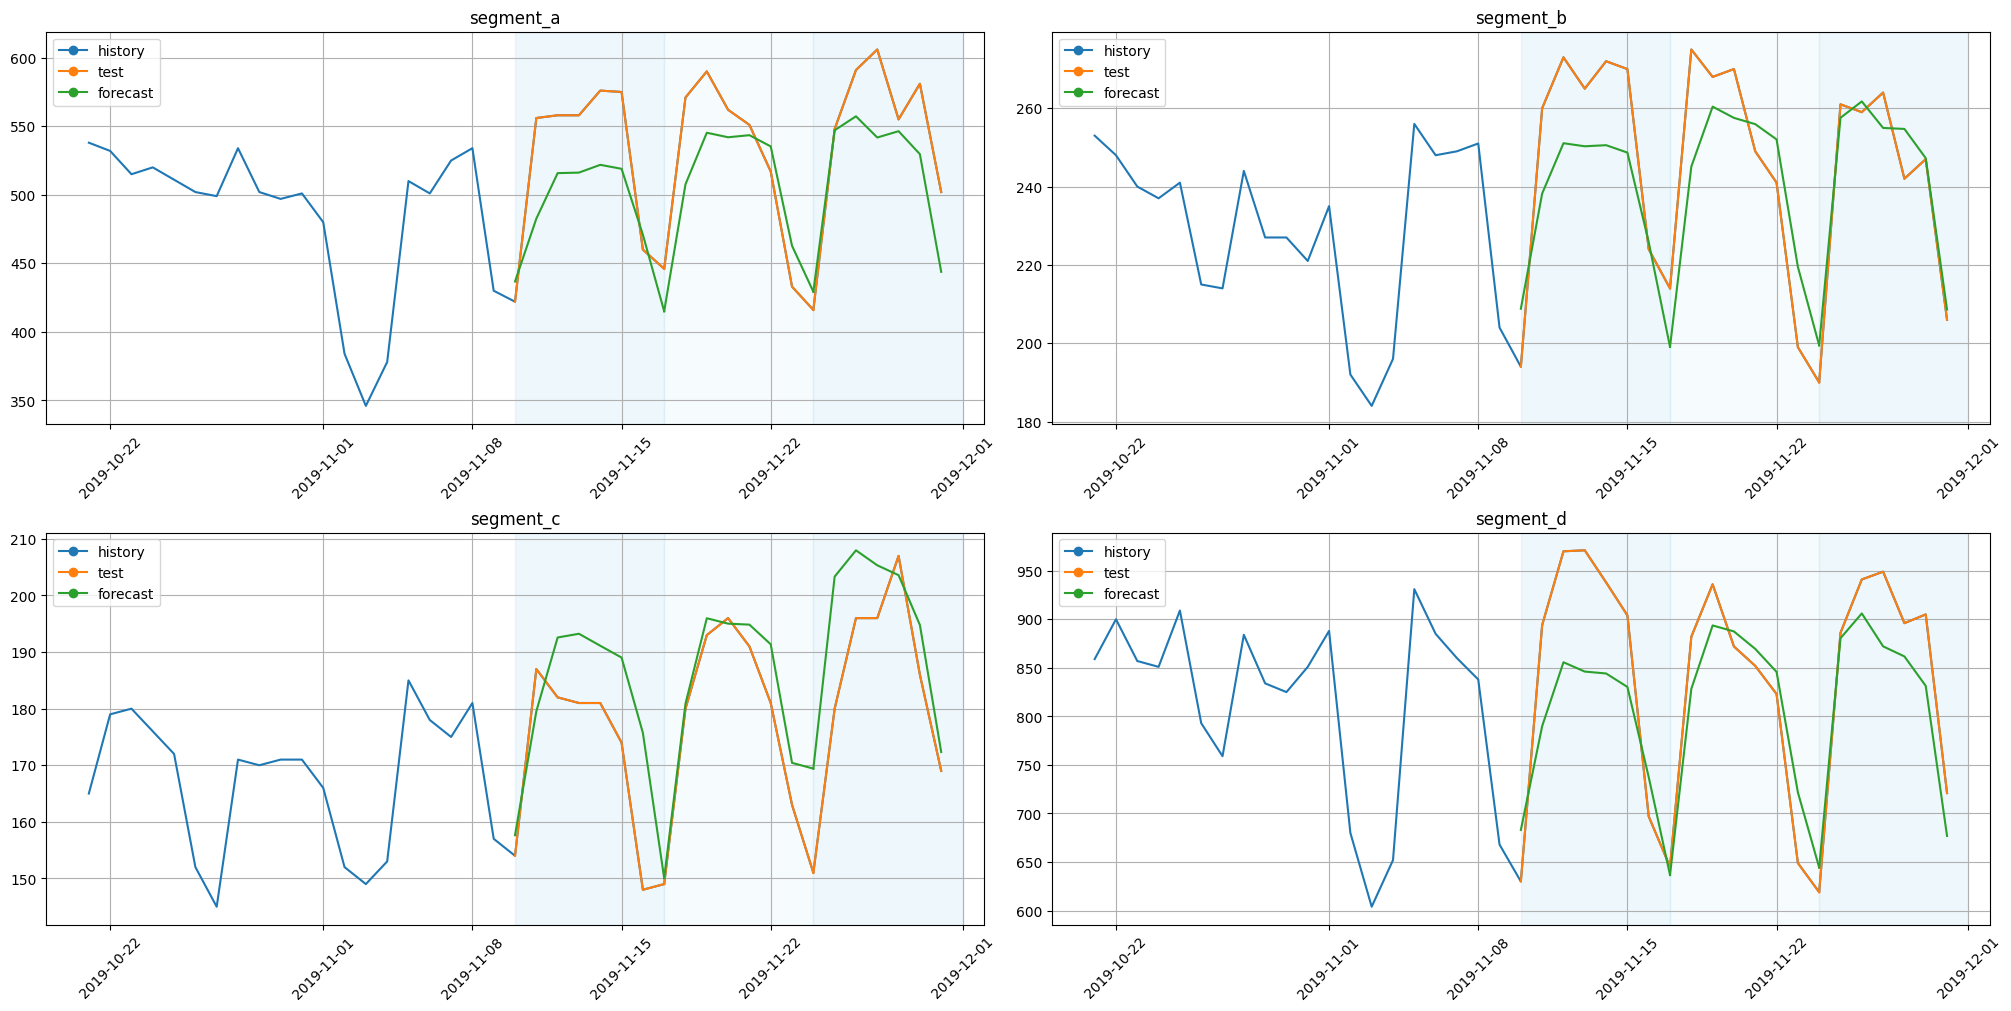

In [ ]:
plot_backtest(forecast_rnn, ts, history_len=20)

### 2.5. N-BEATS Model <a class="anchor" id="section_3_6"></a>

Эта архитектура основана на обратных и прямых остаточных каналах и глубоком стеке полностью связанных уровней.

В библиотеке есть два типа моделей.  `NBeatsGenericModel` реализует общую модель глубокого обучения, в то время как `NBeatsInterpretableModel` дополняется определенными индуктивными отклонениями, которые можно интерпретировать (тренд и сезонность).


https://openreview.net/pdf?id=r1ecqn4YwB

In [ ]:
from etna.models.nn import NBeatsGenericModel
from etna.models.nn import NBeatsInterpretableModel # есть ещё интерпретируемая версия модели!

In [ ]:
model_nbeats_generic = NBeatsGenericModel(
    input_size=2 * HORIZON,
    output_size=HORIZON,
    loss="smape",
    stacks=30,
    layers=4,
    layer_size=256,
    trainer_params=dict(max_epochs=1000),
    lr=1e-3,
)

pipeline_nbeats_generic = Pipeline(
    model=model_nbeats_generic,
    horizon=HORIZON,
    transforms=[],
)

In [ ]:
metrics_nbeats_generic, forecast_nbeats_generic, _ = pipeline_nbeats_generic.backtest(
    ts, metrics=metrics, n_folds=3, n_jobs=1
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type        | Params
--------------------------------------
0 | model | NBeats      | 206 K 
1 | loss  | NBeatsSMAPE | 0     
--------------------------------------
206 K     Trainable params
0         Non-trainable params
206 K     Total params
0.826     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   56.7s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type        | Params
--------------------------------------
0 | model | NBeats      | 206 K 
1 | loss  | NBeatsSMAPE | 0     
--------------------------------------
206 K     Trainable params
0         Non-trainable params
206 K     Total params
0.826     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:  1.9min
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type        | Params
--------------------------------------
0 | model | NBeats      | 206 K 
1 | loss  | NBeatsSMAPE | 0     
--------------------------------------
206 K     Trainable params
0         Non-trainable params
206 K     Total params
0.826     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  2.8min
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  2.8min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s


In [ ]:
score = metrics_nbeats_generic["SMAPE"].mean()
print(f"Average SMAPE for N-BEATS Generic: {score:.3f}")

Average SMAPE for N-BEATS Generic: 5.865


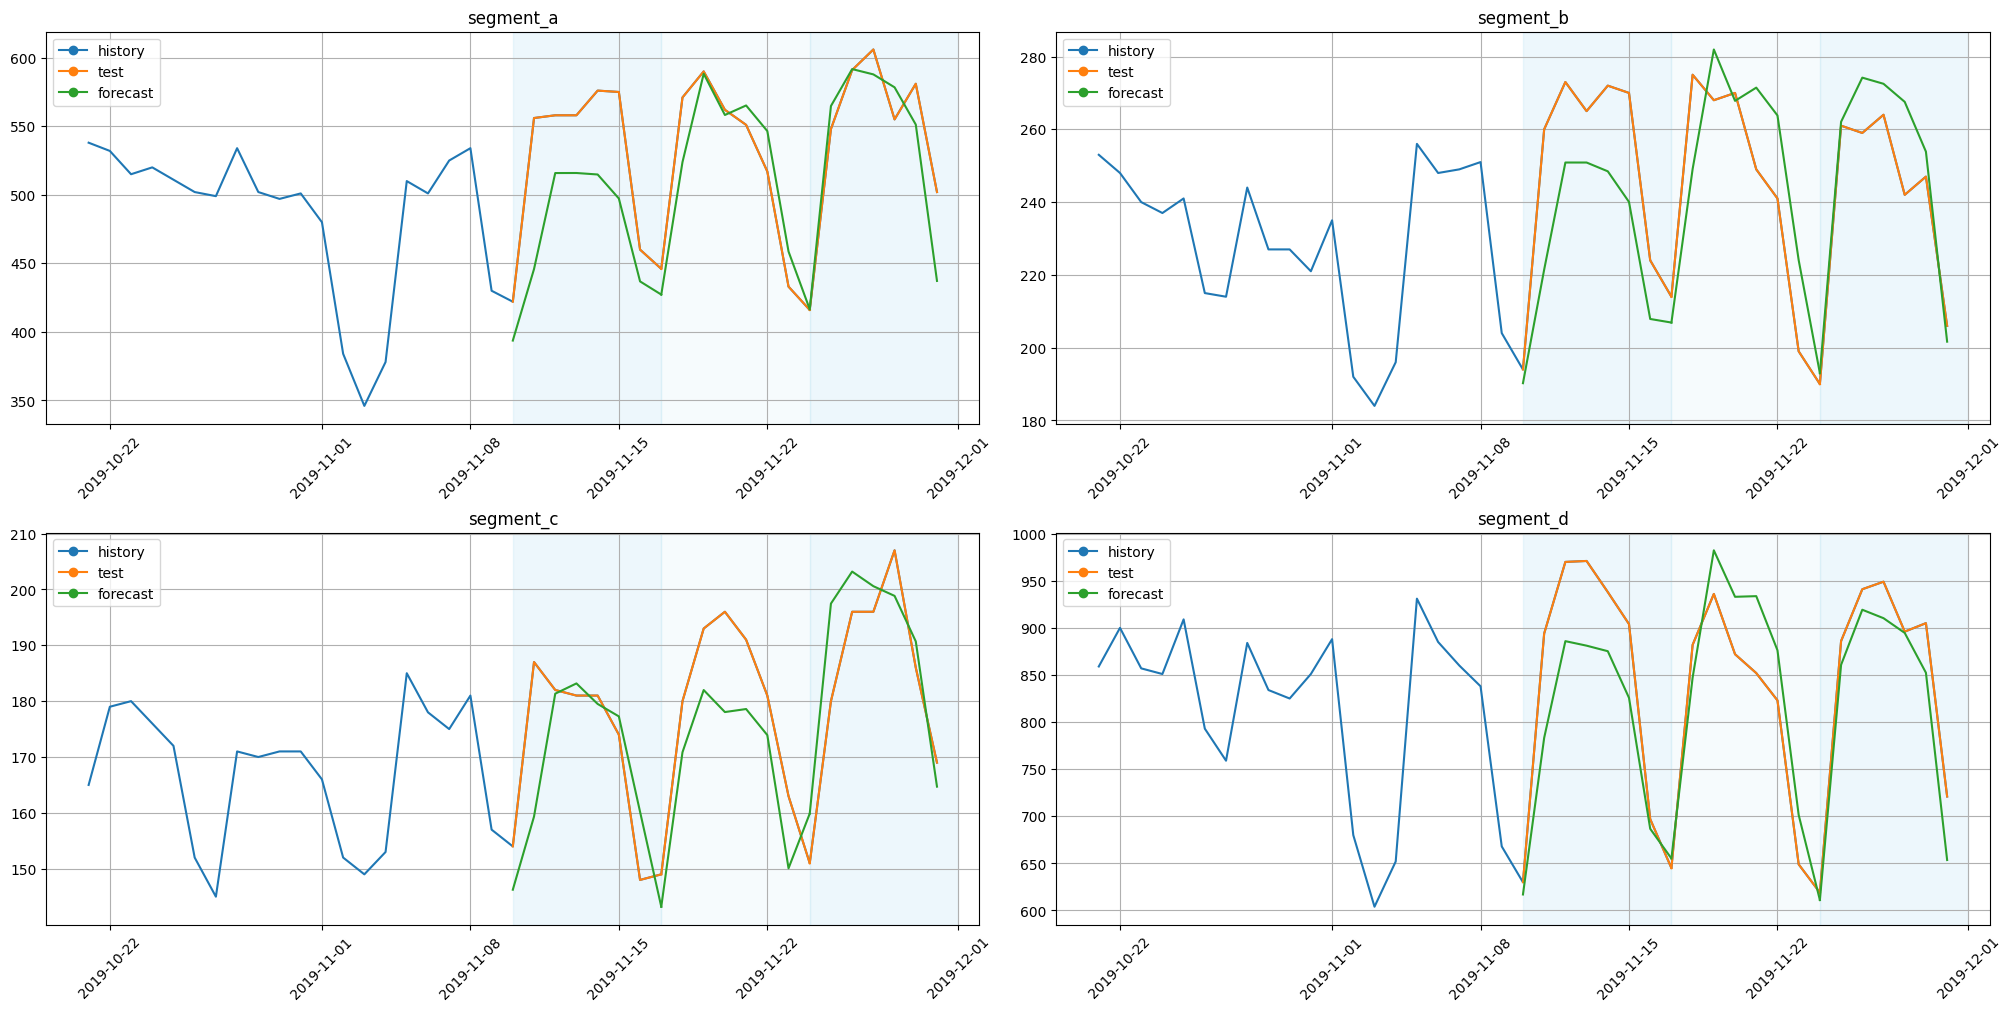

In [ ]:
plot_backtest(forecast_nbeats_generic, ts, history_len=20)